### Import Libraries

In [2]:
# Imports
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import optuna



d:\python\mid_project_raw\flight_delay_dashboard_project\envs\dashboard_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Dataset

In [3]:
# Load data
flight = pd.read_csv('Airline_Delay_Cause.csv')

# Basic dataset overview
#print(flight.shape)         # Rows and columns
#print(flight.info())        # Data types and non-null counts
#print(flight.describe())    # Summary stats
#print(flight.head())        # Preview first 5 rows


### Check for Missing Values

In [4]:
# Check data types and missing values
#print(flight.dtypes)
#print(flight.isnull().sum())

# Check column names
#print(flight.columns)

# 📌 Dataset Column Analysis: Flight Delay Prediction
# The dataset contains monthly aggregated flight arrival statistics for different carriers and airports.
# Each row = unique (carrier, airport, month, year) combination.

# 🔸 Temporal Features:
#   - 'year', 'month': Track seasonal trends and yearly changes.

# 🔸 Airline Info:
#   - 'carrier': IATA code (e.g., 'AA')
#   - 'carrier_name': Full airline name (visuals only)

# 🔸 Airport Info:
#   - 'airport': IATA code (e.g., 'LAX')
#   - 'airport_name': Full airport name (visuals only)

# 🔸 Flight & Delay Counts:
#   - 'arr_flights': Total monthly arriving flights
#   - 'arr_del15': Flights delayed >15 mins (used to calculate delay rate)

# 🔸 Delay Cause Counts (per flight):
#   - 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct'

# 🔸 Cancellation & Diversion:
#   - 'arr_cancelled': Canceled flights
#   - 'arr_diverted': Diverted flights

# 🔸 Delay Duration (in minutes):
#   - 'arr_delay': Total delay minutes
#   - 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'

# ✅ Summary:
# This dataset supports EDA, feature engineering (e.g., delay ratios), and predictive modeling.


### cleaning the data

In [5]:
# 🧹 Data Cleaning

# 1. Check for duplicates
#print("Duplicate rows:", flight.duplicated().sum())

# 2. Missing values summary
missing_summary = flight.isna().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]
#print("\nMissing values per column:")
#print(missing_summary)

# 3. Rows with any missing values
#print("\nRows with missing values:", flight[flight.isna().sum(axis=1) > 0].shape[0])

# 4. Drop missing values
flight.dropna(inplace=True)

# 5. Confirm all missing values are gone
#print("\nRemaining missing values:", flight.isna().sum().sum())
#print("New shape after dropping missing values:", flight.shape)

# 6. Convert key categorical columns to category type
cat_cols = ['carrier', 'carrier_name', 'airport', 'airport_name']
for col in cat_cols:
    flight[col] = flight[col].astype('category')

# 7. Backup categorical columns (good practice)
flight_categorical = flight[cat_cols].copy()
##print("\nSample of categorical backup (first 5 rows):")
##print(flight_categorical.head())

# 8. Check for invalid month values
##print("\nMonth value distribution:")
##print(flight['month'].value_counts().sort_index())

# 9. Confirm arr_flights and arr_del15 should be integers
##print("\narr_flights and arr_del15 stats:")
##print(flight[['arr_flights', 'arr_del15']].describe())

flight['arr_flights'] = flight['arr_flights'].astype(int)
flight['arr_del15'] = flight['arr_del15'].astype(int)

# 10. Final structure check
##print("\nFinal DataFrame info:")
##print(flight.info())

##print("Rows with missing values (final):", flight.isna().any(axis=1).sum())


### feature engineering

In [6]:
# ==============================================================
# 📦 Feature Engineering for Classification (Multiclass Risk)
# --------------------------------------------------------------
# This function adds engineered features used in the classifier pipeline.
# It creates 'delay_ratio' and computes 'delay_risk_level' as the multiclass target:
#   - 0 = Low Risk   (≤ 20%)
#   - 1 = Moderate   (20–40%)
#   - 2 = High Risk  (> 40%)
# ==============================================================
def feature_engineering_classifier(df):
    df = df.copy()

    # Normalize rates
    df['delay_ratio'] = df['arr_del15'] / df['arr_flights']
    df['cancellation_rate'] = df['arr_cancelled'] / df['arr_flights']
    df['diversion_rate'] = df['arr_diverted'] / df['arr_flights']

    # Total delay
    delay_cols = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
    df['total_delay'] = df[delay_cols].sum(axis=1)

    # Prevent division by 0 → replace total_delay = 0 with NaN, then fill %s with 0
    df['total_delay'] = df['total_delay'].replace(0, np.nan)
    for col in delay_cols:
        new_col = col.replace('_delay', '_delay_pct')
        df[new_col] = df[col] / df['total_delay']
    pct_cols = [col.replace('_delay', '_delay_pct') for col in delay_cols]
    df[pct_cols] = df[pct_cols].fillna(0)

    # Year-Month
    df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

    # Season
    df['season'] = df['month'].apply(lambda m: (
        'Winter' if m in [12, 1, 2] else
        'Spring' if m in [3, 4, 5] else
        'Summer' if m in [6, 7, 8] else
        'Fall'
    ))

    # Carrier total flights
    carrier_flight_counts = df.groupby('carrier', observed=False)['arr_flights'].transform('sum')
    df['carrier_total_flights'] = carrier_flight_counts

    # Airport delay rate
    airport_delay_ratio = df.groupby('airport', observed=False).apply(
        lambda x: x['arr_del15'].sum() / x['arr_flights'].sum()
    )
    df['airport_delay_rate'] = df['airport'].map(airport_delay_ratio)

    # Disruption flag
    df['disrupted'] = ((df['arr_cancelled'] > 0) | (df['arr_diverted'] > 0)).astype(int)

    # Risk classification
    def classify_risk(ratio):
        if ratio <= 0.20:
            return 0
        elif ratio <= 0.40:
            return 1
        else:
            return 2
    df['delay_risk_level'] = df['delay_ratio'].apply(classify_risk)

    # Mean delay per flight
    df['mean_delay_per_flight'] = df['total_delay'] / df['arr_flights']
    df['mean_delay_per_flight'] = df['mean_delay_per_flight'].fillna(0)

    # Dominant delay cause
    df['dominant_delay_cause'] = df[delay_cols].idxmax(axis=1)

    # Monthly delay rate
    month_delay = df.groupby('month', observed=False).apply(
        lambda x: x['arr_del15'].sum() / x['arr_flights'].sum()
    )
    df['month_delay_rate'] = df['month'].map(month_delay)

    # Delay pressure
    df['carrier_vs_airport_ratio'] = df['carrier_delay_pct'] / (
        df['weather_delay_pct'] + df['nas_delay_pct'] + 1e-6
    )

    # Seasonal-airport combo
    df['season_airport_combo'] = df['season'].astype(str) + '_' + df['airport'].astype(str)
    season_airport_delay = df.groupby('season_airport_combo', observed=False).apply(
        lambda x: x['arr_del15'].sum() / x['arr_flights'].sum()
    )
    df['season_airport_delay_rate'] = df['season_airport_combo'].map(season_airport_delay)

    # ✅ NaN check
    if df.isna().sum().sum() > 0:
        print("⚠️ Warning: NaNs detected in engineered features")

    return df


### Train,validation and test split then applying feature engineering

In [7]:
# ==============================================================
# 📊 Train/Validation/Test Split for Classification Pipeline
# --------------------------------------------------------------
# - Split BEFORE feature engineering to avoid leakage
# - 70% train / 15% validation / 15% test
# ==============================================================

# STEP 1: Copy raw data before any engineered columns
raw_df = flight.copy()

# STEP 2: First split → 85% train_val, 15% test
X_raw_trainval, X_raw_test = train_test_split(raw_df, test_size=0.15, random_state=42)

# STEP 3: Second split → train (70%) and validation (15%)
X_raw_train, X_raw_val = train_test_split(X_raw_trainval, test_size=0.1765, random_state=42)  # ≈ 15% of total

# STEP 4: Feature Engineering (separately to prevent leakage)
X_train_fe = feature_engineering_classifier(X_raw_train)
X_val_fe   = feature_engineering_classifier(X_raw_val)
X_test_fe  = feature_engineering_classifier(X_raw_test)

# STEP 5: Extract multiclass target for classifier
y_train_class = X_train_fe['delay_risk_level']
y_val_class   = X_val_fe['delay_risk_level']
y_test_class  = X_test_fe['delay_risk_level']

# STEP 6: Drop target from feature sets
X_train_fe.drop(['delay_risk_level'], axis=1, inplace=True)
X_val_fe.drop(['delay_risk_level'], axis=1, inplace=True)
X_test_fe.drop(['delay_risk_level'], axis=1, inplace=True)


C:\Users\omar yasser\AppData\Local\Temp\ipykernel_15760\706567613.py:47: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['arr_del15'].sum() / x['arr_flights'].sum()


⚠️ Warning: NaNs detected in engineered features


C:\Users\omar yasser\AppData\Local\Temp\ipykernel_15760\706567613.py:47: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['arr_del15'].sum() / x['arr_flights'].sum()


⚠️ Warning: NaNs detected in engineered features


C:\Users\omar yasser\AppData\Local\Temp\ipykernel_15760\706567613.py:47: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x['arr_del15'].sum() / x['arr_flights'].sum()


⚠️ Warning: NaNs detected in engineered features


### Pre processing

In [8]:
def preprocessing_classifier(df, fit=True, scaler=None, encoder=None):
    """
    Preprocessing for Multiclass Classifier:
    - Drops leakage-prone and irrelevant columns
    - Encodes categorical features using OneHotEncoder
    - Scales numerical features using StandardScaler
    - Saves fitted encoder and scaler globally when fit=True
    """

    global saved_encoder, saved_scaler  # 🔥 Make encoder & scaler globally accessible for dumping

    # 🚫 Drop leaky/unnecessary columns
    drop_cols = [
        'carrier_name', 'airport_name',
        'arr_flights', 'arr_del15',
        'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
        'arr_cancelled', 'arr_diverted',
        'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
        'security_delay', 'late_aircraft_delay', 'total_delay',
        'delay_ratio', 'high_delay_flag',
        'delay_risk_level', 'year_month', 'season_airport_combo'
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # 🧽 Ensure consistency for encoded categorical values
    # 🔁 Force string conversion regardless of dtype
    pass

    # 🧠 Identify features
    categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # 🔤 Encode categorical features
    if fit:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_cat = encoder.fit_transform(df[categorical_cols])
        saved_encoder = encoder  # ✅ Store globally for model dumping
    else:
        encoded_cat = encoder.transform(df[categorical_cols])
    encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)

    # 🔢 Scale numerical features
    if fit:
        scaler = StandardScaler()
        scaled_num = scaler.fit_transform(df[numeric_cols])
        saved_scaler = scaler  # ✅ Store globally for model dumping
    else:
        scaled_num = scaler.transform(df[numeric_cols])
    scaled_num_df = pd.DataFrame(scaled_num, columns=numeric_cols, index=df.index)

    # 🔗 Combine encoded + scaled
    processed_df = pd.concat([scaled_num_df, encoded_cat_df], axis=1)

    # 🚫 Handle remaining NaNs
    processed_df = processed_df.fillna(0)

    # 🚨 Safety check
    if processed_df.isna().sum().sum() > 0:
        print("⚠️ Warning: NaNs detected in processed data")

    return processed_df, scaler, encoder



### Apply Classifier-Specific Preprocessing

In [ ]:
# --------------------------------------------------------------
# Outputs fully processed datasets for training/validation/testing
# ==============================================================

X_train_class_processed, scaler_class, encoder_class = preprocessing_classifier(X_train_fe, fit=True)
X_val_class_processed, _, _ = preprocessing_classifier(X_val_fe, fit=False, scaler=scaler_class, encoder=encoder_class)
X_test_class_processed, _, _ = preprocessing_classifier(X_test_fe, fit=False, scaler=scaler_class, encoder=encoder_class)



### Tests 

In [10]:
print("🧠 Final training features:")
print(X_train_class_processed.dtypes)
print("✅ Columns used:", list(X_train_class_processed.columns))
         
print("🔢 Columns that were one-hot encoded:", saved_encoder.get_feature_names_out())


🧠 Final training features:
year                                        float64
month                                       float64
cancellation_rate                           float64
diversion_rate                              float64
carrier_delay_pct                           float64
                                             ...   
dominant_delay_cause_carrier_delay          float64
dominant_delay_cause_late_aircraft_delay    float64
dominant_delay_cause_nas_delay              float64
dominant_delay_cause_security_delay         float64
dominant_delay_cause_weather_delay          float64
Length: 434, dtype: object
✅ Columns used: ['year', 'month', 'cancellation_rate', 'diversion_rate', 'carrier_delay_pct', 'weather_delay_pct', 'nas_delay_pct', 'security_delay_pct', 'late_aircraft_delay_pct', 'airport_delay_rate', 'mean_delay_per_flight', 'month_delay_rate', 'carrier_vs_airport_ratio', 'season_airport_delay_rate', 'carrier_9E', 'carrier_AA', 'carrier_AS', 'carrier_B6', 'carrier_DL',

### checking for class imbalance

In [11]:
#class imbalance check
import pandas as pd

# Calculate class distribution for each split
class_distribution = {
    "Train": y_train_class.value_counts(normalize=True).sort_index(),
    "Validation": y_val_class.value_counts(normalize=True).sort_index(),
    "Test": y_test_class.value_counts(normalize=True).sort_index()
}

# Convert to DataFrame (in percentage)
class_dist_df = pd.DataFrame(class_distribution).T
class_dist_df.columns = ['Low Risk (0)', 'Moderate Risk (1)', 'High Risk (2)']
class_dist_df = class_dist_df * 100  # Convert to %

# Show as table
print("📊 Class Distribution (%)")
display(class_dist_df)


📊 Class Distribution (%)


,Low Risk (0),Moderate Risk (1),High Risk (2)
Train,61.989470,34.738968,3.271562
Validation,61.947213,34.685456,3.367331
Test,62.186575,34.285937,3.527488


### Applying smote

In [13]:
#due to heavy imbalance smote is applied
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE on classifier training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_class_processed, y_train_class)

# Optional: Check new class distribution
print("✅ Resampled training set class distribution:")
print(pd.Series(y_train_balanced).value_counts())


✅ Resampled training set class distribution:
delay_risk_level
0    74295
1    74295
2    74295
Name: count, dtype: int64


### Applying ADASYN and compairing to smote

In [14]:
'''
from imblearn.over_sampling import ADASYN
from collections import Counter

# Apply SMOTE on classifier training data only
smote = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_class_processed, y_train_class)

# Optional: Check new class distribution
print("✅ Resampled training set class distribution:")
print(pd.Series(y_train_balanced).value_counts())
'''

'\nfrom imblearn.over_sampling import ADASYN\nfrom collections import Counter\n\n# Apply SMOTE on classifier training data only\nsmote = ADASYN(random_state=42)\nX_train_balanced, y_train_balanced = smote.fit_resample(X_train_class_processed, y_train_class)\n\n# Optional: Check new class distribution\nprint("✅ Resampled training set class distribution:")\nprint(pd.Series(y_train_balanced).value_counts())\n'

### Applying ADASYN and comparing to Smote

In [15]:
'''#due to heavy imbalance smote is applied
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

# Apply SMOTE on classifier training data only
smote = BorderlineSMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_class_processed, y_train_class)

# Optional: Check new class distribution
print("✅ Resampled training set class distribution:")
print(pd.Series(y_train_balanced).value_counts())
'''

'#due to heavy imbalance smote is applied\nfrom imblearn.over_sampling import BorderlineSMOTE\nfrom collections import Counter\n\n# Apply SMOTE on classifier training data only\nsmote = BorderlineSMOTE(random_state=42)\nX_train_balanced, y_train_balanced = smote.fit_resample(X_train_class_processed, y_train_class)\n\n# Optional: Check new class distribution\nprint("✅ Resampled training set class distribution:")\nprint(pd.Series(y_train_balanced).value_counts())\n'

### Optimizing with optuna

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),  # smaller range = faster
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "tree_method": "hist",
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 3,
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": 0
    }

    weights = compute_class_weight("balanced", classes=np.array([0, 1, 2]), y=y_train_balanced)
    sample_weights = pd.Series(y_train_balanced).map(dict(enumerate(weights)))

    model = XGBClassifier(**params)
    model.fit(
        X_train_balanced, y_train_balanced,
        sample_weight=sample_weights,
        eval_set=[(X_val_class_processed, y_val_class)],
        verbose=False
    )

    preds = model.predict(X_val_class_processed)
    return f1_score(y_val_class, preds, average="macro")


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # ⬅️ NOT 1


[I 2025-06-11 15:50:43,330] A new study created in memory with name: no-name-cb46da7c-20b4-4866-a60d-9a1046e8ad2a
[I 2025-06-11 15:51:55,946] Trial 0 finished with value: 0.7100381381465838 and parameters: {'n_estimators': 174, 'max_depth': 4, 'learning_rate': 0.08517968818853446, 'subsample': 0.9635798214102181, 'colsample_bytree': 0.8412347296103792}. Best is trial 0 with value: 0.7100381381465838.


### Model training

In [17]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import joblib
import os
import numpy as np
import pandas as pd

# === Define model ===
best_model = XGBClassifier(
    **study.best_params,
    tree_method="hist",
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss"
)

# === Compute sample weights ===
weights = compute_class_weight("balanced", classes=np.array([0, 1, 2]), y=y_train_balanced)
sample_weights = pd.Series(y_train_balanced).map(dict(enumerate(weights)))

# === Train the model ===
best_model.fit(
    X_train_balanced,                 # ✅ Must be a DataFrame
    y_train_balanced,
    sample_weight=sample_weights,
    eval_set=[(X_val_class_processed, y_val_class)],  # ✅ Also a DataFrame
    verbose=True
)


# === Evaluate model ===
print("\n📊 Classification Report (Train):")
print(classification_report(y_train_class, best_model.predict(X_train_class_processed)))

print("\n📊 Classification Report (Val):")
print(classification_report(y_val_class, best_model.predict(X_val_class_processed)))

print("\n📊 Classification Report (Test):")
print(classification_report(y_test_class, best_model.predict(X_test_class_processed)))

# === Save model with joblib ===
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)
joblib.dump(best_model, os.path.join(models_dir, "model_classifier.pkl"))
print("✅ Model exported to 'models/model_classifier.pkl'")



[0]	validation_0-mlogloss:1.03092
[1]	validation_0-mlogloss:0.99476
[2]	validation_0-mlogloss:0.94123
[3]	validation_0-mlogloss:0.91244
[4]	validation_0-mlogloss:0.89292
[5]	validation_0-mlogloss:0.85183
[6]	validation_0-mlogloss:0.81549
[7]	validation_0-mlogloss:0.78382
[8]	validation_0-mlogloss:0.75521
[9]	validation_0-mlogloss:0.72958
[10]	validation_0-mlogloss:0.70634
[11]	validation_0-mlogloss:0.69468
[12]	validation_0-mlogloss:0.67804
[13]	validation_0-mlogloss:0.66280
[14]	validation_0-mlogloss:0.64906
[15]	validation_0-mlogloss:0.63615
[16]	validation_0-mlogloss:0.62470
[17]	validation_0-mlogloss:0.61412
[18]	validation_0-mlogloss:0.60425
[19]	validation_0-mlogloss:0.59308
[20]	validation_0-mlogloss:0.58410
[21]	validation_0-mlogloss:0.57594
[22]	validation_0-mlogloss:0.56853
[23]	validation_0-mlogloss:0.56316
[24]	validation_0-mlogloss:0.55531
[25]	validation_0-mlogloss:0.54928
[26]	validation_0-mlogloss:0.54251
[27]	validation_0-mlogloss:0.53636
[28]	validation_0-mlogloss:0.5

### Tests because the joblib dumb was corrupted

In [2]:
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os

# === 1. Create dummy classification data ===
X, y = make_classification(
    n_samples=500,
    n_features=15,
    n_informative=10,
    n_classes=3,
    random_state=42
)

# === 2. Split data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. Create and train test model ===
test_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    verbosity=0,
    tree_method="hist"  # fast training
)

test_model.fit(X_train, y_train)

# === 4. Evaluate briefly ===
print("📊 Quick Evaluation:")
print(classification_report(y_test, test_model.predict(X_test)))

# === 5. Export safely using native .json format
os.makedirs("models", exist_ok=True)
test_model.save_model("models/model_classifier_test.json")
print("✅ Model exported safely to models/model_classifier_test.json")


📊 Quick Evaluation:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        35
           1       0.91      0.77      0.83        26
           2       0.87      0.87      0.87        39

    accuracy                           0.86       100
   macro avg       0.87      0.85      0.86       100
weighted avg       0.86      0.86      0.86       100

✅ Model exported safely to models/model_classifier_test.json


### Joblib dumb

In [114]:
from xgboost import XGBClassifier
import joblib

print(type(best_model))  # Must output: <class 'xgboost.sklearn.XGBClassifier'>


<class 'xgboost.sklearn.XGBClassifier'>


### More tests

In [121]:
# Export the model
joblib.dump(best_model, "model_classifier.pkl")

# ✅ Optional: immediately load to verify
test_model = joblib.load("model_classifier.pkl")
print(test_model.get_booster().feature_names[:5])  # Confirm it has names
import os
os.getcwd()
import zipfile
with zipfile.ZipFile("model_classifier_OKAYNOW.zip", "w") as zipf:
    zipf.write("model_classifier_final.pkl")



['year', 'month', 'cancellation_rate', 'diversion_rate', 'carrier_delay_pct']


In [123]:
from xgboost import XGBClassifier
import joblib

model = joblib.load("model_classifier_final.pkl")
booster = model.get_booster()

if booster.feature_names is None:
    print("❌ Feature names missing in booster.")
else:
    print("✅ Booster feature names found.")
    print("Total features:", len(booster.feature_names))
    print("Example:", booster.feature_names[:10])

import json

with open("feature_names_classifier.json", "w") as f:
    json.dump(booster.feature_names, f)


✅ Booster feature names found.
Total features: 434
Example: ['year', 'month', 'cancellation_rate', 'diversion_rate', 'carrier_delay_pct', 'weather_delay_pct', 'nas_delay_pct', 'security_delay_pct', 'late_aircraft_delay_pct', 'airport_delay_rate']


### Import Libraries

In [101]:

import joblib

joblib.dump(saved_encoder, "encoder_classifier.pkl")
joblib.dump(saved_scaler, "scaler_classifier.pkl")
joblib.dump(best_model, "model_classifier.pkl")

best_model.save_model("model_classifier.json")  # Safe format



### Import Libraries

In [ ]:
import joblib

# Save the trained model to file
joblib.dump(best_model, "xgb_50_optuna_trials_model.pkl")

# You can load it later with:
# model = joblib.load("xgb_final_model.pkl")


['xgb_50_optuna_trials_model.pkl']

### Threshold testing as a try to improve the results due to class imbalance

📊 Threshold Tuning: Full Per-Class Report


,Threshold Set,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 1 Precision,Class 1 Recall,Class 1 F1,Class 2 Precision,Class 2 Recall,Class 2 F1,Macro F1,Accuracy
0,Penalty Class 2 False Positives,0.9394,0.8426,0.8884,0.7316,0.8673,0.7937,0.5770,0.5676,0.5723,0.7515,0.8419
1,Favor Class 1,0.9633,0.7744,0.8586,0.6738,0.9102,0.7744,0.5721,0.5688,0.5704,0.7345,0.8146
2,Default (0.33 each),0.9398,0.8421,0.8882,0.7342,0.8403,0.7837,0.4789,0.6821,0.5627,0.7449,0.8361
3,Balance Class 1 & 2,0.9634,0.7740,0.8583,0.6748,0.8825,0.7648,0.4740,0.6855,0.5605,0.7279,0.8086
4,Sharpen Class 2,0.9398,0.8421,0.8882,0.7349,0.8320,0.7804,0.4583,0.7110,0.5573,0.7420,0.8342
5,Soft Boost for Class 2,0.9400,0.8418,0.8882,0.7357,0.8249,0.7777,0.4416,0.7387,0.5528,0.7396,0.8325
6,Aggressive Boost for Class 2,0.9405,0.8409,0.8879,0.7354,0.7987,0.7657,0.3890,0.8023,0.5240,0.7259,0.8249
7,High Confidence Class 2,0.9408,0.8402,0.8876,0.7342,0.7692,0.7513,0.3452,0.8543,0.4917,0.7102,0.8161


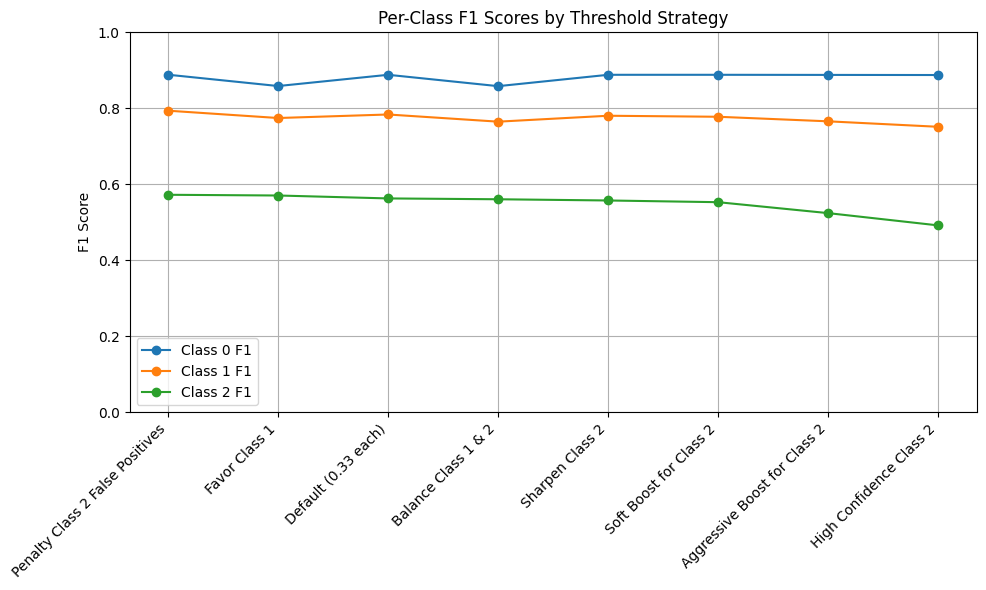

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Predict class probabilities on the validation set
val_probs = best_model.predict_proba(X_val_class_processed)

# Define threshold sets to try
threshold_sets = {
    "Default (0.33 each)": [0.33, 0.33, 0.33],
    "Soft Boost for Class 2": [0.3, 0.3, 0.4],
    "Aggressive Boost for Class 2": [0.25, 0.25, 0.5],
    "High Confidence Class 2": [0.2, 0.2, 0.6],
    "Penalty Class 2 False Positives": [0.4, 0.4, 0.2],
    "Favor Class 1": [0.25, 0.5, 0.25],
    "Sharpen Class 2": [0.3, 0.3, 0.35],
    "Balance Class 1 & 2": [0.2, 0.4, 0.4],
}

# Collect all results
all_results = []

for label, weights in threshold_sets.items():
    weights = np.array(weights) / np.sum(weights)  # normalize
    preds = np.argmax(val_probs * weights, axis=1)
    report = classification_report(y_val_class, preds, output_dict=True, zero_division=0)

    all_results.append({
        "Threshold Set": label,
        "Class 0 Precision": round(report["0"]["precision"], 4),
        "Class 0 Recall": round(report["0"]["recall"], 4),
        "Class 0 F1": round(report["0"]["f1-score"], 4),
        "Class 1 Precision": round(report["1"]["precision"], 4),
        "Class 1 Recall": round(report["1"]["recall"], 4),
        "Class 1 F1": round(report["1"]["f1-score"], 4),
        "Class 2 Precision": round(report["2"]["precision"], 4),
        "Class 2 Recall": round(report["2"]["recall"], 4),
        "Class 2 F1": round(report["2"]["f1-score"], 4),
        "Macro F1": round(report["macro avg"]["f1-score"], 4),
        "Accuracy": round(report["accuracy"], 4),
    })

# Convert to DataFrame and sort by Class 2 F1
df_results = pd.DataFrame(all_results)
df_sorted = df_results.sort_values("Class 2 F1", ascending=False).reset_index(drop=True)

# Display full results
print("📊 Threshold Tuning: Full Per-Class Report")
display(df_sorted)

# Optional: Plot class-wise F1-scores for each threshold set
fig, ax = plt.subplots(figsize=(10, 6))
for cls in ["Class 0 F1", "Class 1 F1", "Class 2 F1"]:
    ax.plot(df_sorted["Threshold Set"], df_sorted[cls], marker='o', label=cls)
plt.title("Per-Class F1 Scores by Threshold Strategy")
plt.ylabel("F1 Score")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Output the best thresholds for the backend code

In [17]:
import json

# Define the top 3 threshold sets
best_thresholds = {
    "Best Overall (Penalty Class 2 False Positives)": [0.4, 0.4, 0.2],
    "Best Recall (High Confidence Class 2)": [0.2, 0.2, 0.6],
    "Best Precision (Penalty Class 2 False Positives)": [0.4, 0.4, 0.2]
}

# Save to JSON file
with open("best_thresholds.json", "w") as f:
    json.dump(best_thresholds, f, indent=4)

print("✅ Thresholds saved to best_thresholds.json")


✅ Thresholds saved to best_thresholds.json


### Import Libraries

📊 Classification Report (Custom Thresholds):
              precision    recall  f1-score   support

           0     0.9400    0.8418    0.8882     15913
           1     0.7357    0.8249    0.7777      8910
           2     0.4416    0.7387    0.5528       865

    accuracy                         0.8325     25688
   macro avg     0.7058    0.8018    0.7396     25688
weighted avg     0.8523    0.8325    0.8386     25688



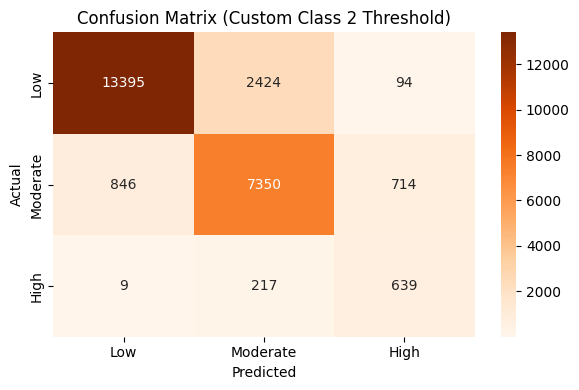

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_probs = best_model.predict_proba(X_val_class_processed)

# Adjust threshold to boost class 2 detection
thresholds = [0.3, 0.3, 0.4]
adjusted_preds = np.argmax(y_probs * thresholds, axis=1)

print("📊 Classification Report (Custom Thresholds):")
print(classification_report(y_val_class, adjusted_preds, digits=4))
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val_class, adjusted_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Low', 'Moderate', 'High'],
            yticklabels=['Low', 'Moderate', 'High'])
plt.title("Confusion Matrix (Custom Class 2 Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


### Import Libraries

### tests

📊 Classification Report (Test Set with Custom Thresholds):
              precision    recall  f1-score   support

           0     0.9376    0.8454    0.8891     15972
           1     0.7297    0.8661    0.7921      8806
           2     0.6166    0.5662    0.5903       906

    accuracy                         0.8426     25684
   macro avg     0.7613    0.7592    0.7572     25684
weighted avg     0.8550    0.8426    0.8453     25684



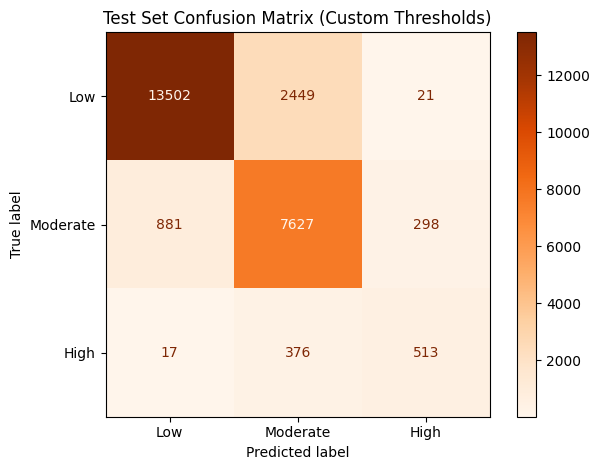

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use your chosen thresholds
best_thresholds = [0.4, 0.4, 0.2]

# Get predicted probabilities on test set
y_test_probs = best_model.predict_proba(X_test_class_processed)

# Apply threshold scaling
y_test_preds = np.argmax(y_test_probs * best_thresholds, axis=1)

# Print detailed classification report
print("📊 Classification Report (Test Set with Custom Thresholds):")
print(classification_report(y_test_class, y_test_preds, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_test_class, y_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Moderate", "High"])
disp.plot(cmap="Oranges")
plt.title("Test Set Confusion Matrix (Custom Thresholds)")
plt.tight_layout()
plt.show()


### Import Libraries

<Figure size 1000x600 with 0 Axes>

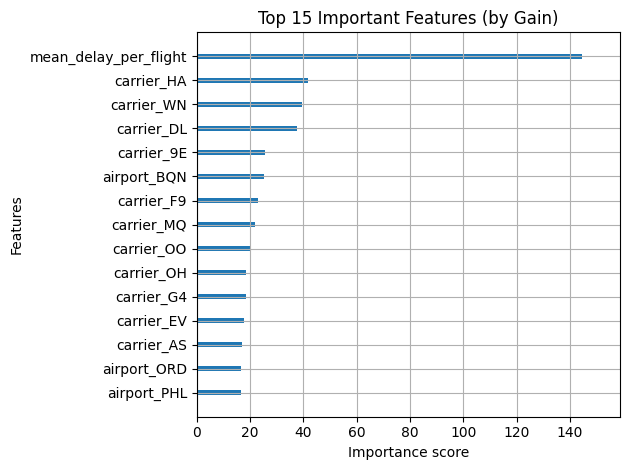

In [21]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot top 15 features by importance (gain-based)
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=15, importance_type="gain", show_values=False)
plt.title("Top 15 Important Features (by Gain)")
plt.tight_layout()
plt.show()
